In [1]:
from models.ccmodel import CCModel
from models.rsmodel import RSModel
from models.bomodel import BOModel
from models.confi import *
from models.utilfuncs import *
from graph import *
import pandas as pd
from tqdm import tqdm
import random

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading in the ECGs and labels
aucs = pd.read_csv("new_simu-data/Heart1/Heart1_AUCS.csv", header=None).to_numpy()
ecgs = pd.read_csv("new_simu-data/Heart1/Heart1_SimuData_4000.csv", header=None).to_numpy()
labels = pd.read_csv("new_simu-data/Heart1/Coord1_4000.csv", header=None).to_numpy() / 1000

In [3]:
total_cases = 0
alle, all_points = [], []
cc_euclids = [[] for _ in range(NUM_STEPS + 21)]                    # Random init CC arrays
cc_successes, cc_avg_sites = [], []
cc_drop = []
# Set mm threshold for finding nearest
mm_thres = 200000

In [4]:
def get_random_dataset(data, coords):
    """
    Handles getting the random dataset for the randomly initialized models
    :param target_coord: target coordinate
    :param data: full dataset for a patient
    :param coords: full labels for a patient
    :return: x, y of size 4
    """
    indices = np.random.choice(range(0, data.shape[0]), NUM_POINTS_START, replace=False)
    return data[indices], coords[indices]

In [5]:
def model_run(model, x, y, train, labels, target, target_coord, target_raw, successes, avg_sites, all_euclids):
    """
    Handles running a single runthrough of a given model on a target site
    Train and labels are the initialized sets to start with (either random or by segment prediction)
    """
    # Run the training loop for the model
    euclids, preds, sites, success, nsites = model.run(x, y, train, labels, target, target_coord, target_raw)
    sites = np.asarray(sites)

    # Add to arrays if successful and add the per steps error
    if success:
        successes.append(euclids[-1])
        avg_sites.append(nsites)
    for j in range(len(euclids)):
        all_euclids[j].append(euclids[j])
        # if j != 0:
        #     drop.append(euclids[j] - euclids[j - 1])
    return successes, avg_sites, all_euclids, sites

In [6]:
cc_model = CCModel(leads=LEADS, steps=10, svr_c=SVR_C, cc=CC_THRES, cc_succ=CC_SUCC,
                   mm=mm_thres, samp_raw=ecgs, samp_coords=labels)
rs_model = RSModel(steps=NUM_STEPS, svr_c=SVR_C, samp_raw=ecgs, samp_coords=labels, cc_succ=CC_SUCC)

In [7]:
# for target, target_coord, target_raw, idx in tqdm(zip(aucs, labels, ecgs, range(len(labels)))):
#     if idx > 0:
#         break
idx = np.random.randint(0,1999,1)[0]
target = aucs[idx]
target_coord = labels[idx]
target_raw = ecgs[idx]

# Drop the target from the training set
if idx == 0:
    x, y, raw = aucs[idx + 1:, :], labels[idx + 1:], ecgs[idx + 1:, :]
else:
    x = np.concatenate((aucs[:idx, :], aucs[idx + 1:, :]))
    y = np.concatenate((labels[:idx], labels[idx + 1:]))
    raw = np.concatenate((ecgs[:idx], ecgs[idx + 1:]))

# Looping through every point to test, n number of times for variance in initialization
# for _ in range(2):
    # Get initial datasets for random and segment initializations
random_x, random_y = get_random_dataset(x, y)
# cc_successes, cc_avg_sites, cc_euclids,sites = model_run(cc_model, x, y, random_x, random_y,
#                                                          target, target_coord, target_raw,
#                                                          cc_successes, cc_avg_sites, cc_euclids)
cc_euclids, cc_preds, cc_sites, success, num_sites = cc_model.run(x, y, random_x, random_y,
                                                         target, target_coord, target_raw)

In [8]:
cc_euclids

[49.667320104956964,
 50.810280367522964,
 48.035771928079384,
 47.48449554235758,
 49.790601368532414,
 50.70557603395503,
 58.65770510210599,
 57.969873055978326,
 48.42558179252622,
 49.23663022321383,
 51.31099543993696,
 52.187855597556094,
 56.82131102017971,
 57.40193696797177,
 62.40038148836197,
 63.250562375737886,
 62.750553704523654,
 62.24873346588339,
 69.85721353087203,
 75.71707677823585,
 74.69755153599081]

In [13]:
success

False

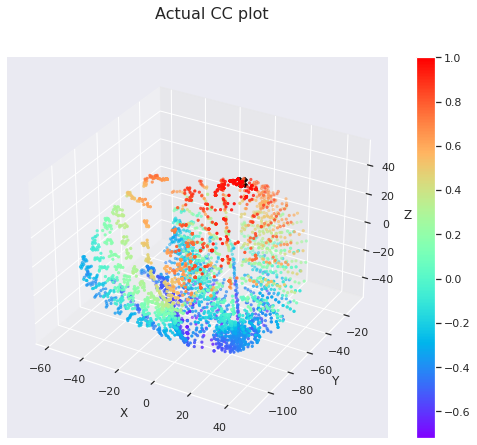

In [10]:
graph_cc_distribution(target_raw,ecgs,labels)

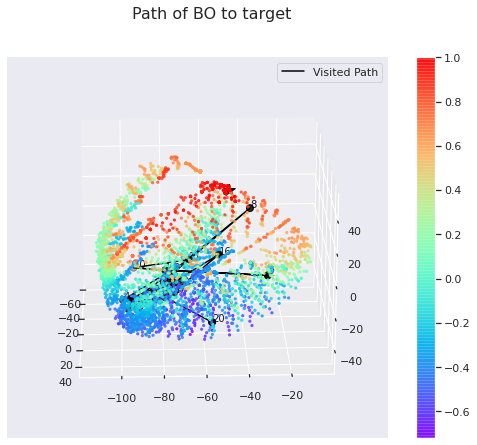

In [15]:
cc_model_graph(target_coord,target_raw,ecgs,labels,cc_sites)